# Generating faces with GANs

This is a small project where I train a GAN to generate faces based on the CelebA Dataset. It was made with Tensorflow and trained on Google Colab.

Import dependencies

In [ ]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

Import two libraries to perform image preprocessing and create the layers of the network

In [ ]:
from ops import *
from utils import *
%load_ext autoreload
%autoreload 2

Script to download the CelebA Dataset

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)


In [ ]:
# TAKE ID FROM SHAREABLE LINK
file_id = "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
# DESTINATION FILE ON YOUR DISK
destination = "celebA.zip"
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip -qq celebA.zip

## Network architecture

Constant variables below depends on your dataset and choosing of architecture.

In [ ]:
DATA_PATH = "img_align_celeba/"

In [ ]:
Z_DIM=100
GENERATOR_DENSE_SIZE= 64*8

IMAGE_SIZE= 64
BATCH_SIZE= 64 
N_CHANNELS = 3 

# Number of images in merged image for visualization
MERGE_X = 8 
MERGE_Y = 8

### Generator

Architecture of the generator tips:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Source: https://github.com/soumith/ganhacks

In [2]:
def generator(z, is_training):

    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    g_batch_norm_l0 = batch_norm(name='g_batch_norm_l0')
    h_bn_l0 = g_batch_norm_l0(h_in,is_training)
    h_l0_a = lrelu(h_bn_l0,name='g_lr_l0')
   
    h_dconv_l1=deconv2d(h_l0_a,output_shape=[BATCH_SIZE,8,8,512],name='g_dconv_l1')
    g_batch_norm_l1 = batch_norm(name='g_batch_norm_l1')
    h_bn_l1 = g_batch_norm_l1(h_dconv_l1,is_training)
    h_l1_a = lrelu(h_bn_l1,name='g_lr_l1')
    h_l1_a_dr = tf.nn.dropout(h_l1_a, 0.5, name='g_dr_l1')
    
    h_dconv_l2=deconv2d(h_l1_a_dr,output_shape=[BATCH_SIZE,16,16,256],name='g_dconv_l2')
    g_batch_norm_l2 = batch_norm(name='g_batch_norm_l2')
    h_bn_l2 = g_batch_norm_l2(h_dconv_l2,is_training)
    h_l2_a = lrelu(h_bn_l2,name='g_lr_l2')
    h_l2_a_dr = tf.nn.dropout(h_l2_a, 0.5, name='g_dr_l2')
    
    h_dconv_l3=deconv2d(h_l2_a_dr,output_shape=[BATCH_SIZE,32,32,128],name='g_dconv_l3')
    g_batch_norm_l3 = batch_norm(name='g_batch_norm_l3')
    h_bn_l3 = g_batch_norm_l3(h_dconv_l3,is_training)
    h_prev = lrelu(h_bn_l3,name='g_lr_l3')
    
    h_out = deconv2d(h_prev, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name='g_out')

    return tf.nn.tanh(h_out)

### Discriminator

Discriminator's architecture tips:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

In [ ]:
def discriminator(image, is_training, batch_norms=None):
    
    h_conv_l0 = conv2d(image,output_dim=32,name='d_dconv_l0')
    d_batch_norm_l0 = batch_norm(name='d_batch_norm_l0')
    h_bn_l0 = d_batch_norm_l0(h_conv_l0,is_training)
    h_l0_a = lrelu(h_bn_l0,name='d_lr_l0')
    h_l0_p = tf.layers.average_pooling2d(h_l0_a, pool_size=(2, 2), strides=2, name='d_pool_l0')
    
    h_conv_l1 = conv2d(h_l0_p,output_dim=64,name='d_dconv_l1')
    d_batch_norm_l1 = batch_norm(name='d_batch_norm_l1')
    h_bn_l1 = d_batch_norm_l1(h_conv_l1,is_training)
    h_l1_a = lrelu(h_bn_l1,name='d_lr_l1')
    h_l1_p = tf.layers.average_pooling2d(h_l1_a, pool_size=(2, 2), strides=2, name='d_pool_l1')
    
    h_conv_l2 = conv2d(h_l1_p,output_dim=128,name='d_dconv_l2')
    d_batch_norm_l2 = batch_norm(name='d_batch_norm_l2')
    h_bn_l2 = d_batch_norm_l2(h_conv_l2,is_training)
    h_l2_a = lrelu(h_bn_l2,name='d_lr_l2')
    h_l2_p = tf.layers.average_pooling2d(h_l2_a, pool_size=(2, 2), strides=2, name='d_pool_l2')
    
    h_l3_fl = tf.layers.flatten(h_l2_p)
    h_l3_lin = linear(h_l3_fl, 256, 'd_h3_lin')
    h_lin_a = lrelu(h_l3_lin, name='d_lr_l3')
    
    linear_out = linear(h_lin_a, 1, 'linear_out')
    
    return tf.nn.sigmoid(linear_out), linear_out

In [ ]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

### Loss functions

$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

In [ ]:
d_loss_real = -tf.reduce_mean(tf.log(D_real + 1e-30))

d_loss_fake = -tf.reduce_mean(tf.log(1 - D_fake + 1e-30))

d_loss = d_loss_real + d_loss_fake

g_loss = -tf.reduce_mean(tf.log(D_fake + 1e-30))

### Optimizers

In [ ]:
tvars = tf.trainable_variables()
d_vars = [v for v in tvars if 'd_' in v.name]
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 
BETA = 0.5

d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

## Training

Load data:

In [ ]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))

Functions for training and evaluations.

In [ ]:
def load(sess, load_dir):
    """
    Function to load network's paramaters
    
    – load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

In [ ]:
def train(sess, load_dir=None, 
          save_frequency=500, 
          sample_frequency=1000, 
          sample_dir='sample_dir',
          save_dir='checkpoint', 
          max_to_keep=1, 
          model_name='dcgan.model',
          n_epochs=10, 
          n_generator_update=2):
  
    """
    Parameters for training

    – load_dir : str, default = None
        path to the folder with parameters
    – save_frequency: int, default = 100
        how often save parameters []
    – sample_frequency: int, default = None (not sample)
        how often sample faces
    – sample_dir: str, default = samples
        directory for sampled images
    – save_dir: str, default = 'checkpoint'
        path where to save parameters
    – max_to_keep: int, default = 1
        how many last checkpoints to store
    – model_name: str, default='dcgan.model'
        name of model
    – n_epochs: int, default = 25 
        number epochs to train
    – n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False})
                save_images(samples, [MERGE_X, MERGE_X],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

In [ ]:
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init_op)
    train(sess, save_dir='checkpoint', load_dir='checkpoint', n_epochs=10)

Take a number of examples to visualize te results of the generator

In [ ]:
new_samples = 10 # 10 batches
counter = 0
new_samples_dir = 'new_samples'
for idx in range(new_samples):    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False})
    for sample in samples:
        plt.imsave(os.path.join(new_samples_dir, 'sample_'+str(counter)+'.png'), (255*inverse_transform(sample)).astype(np.uint8))
        counter += 1

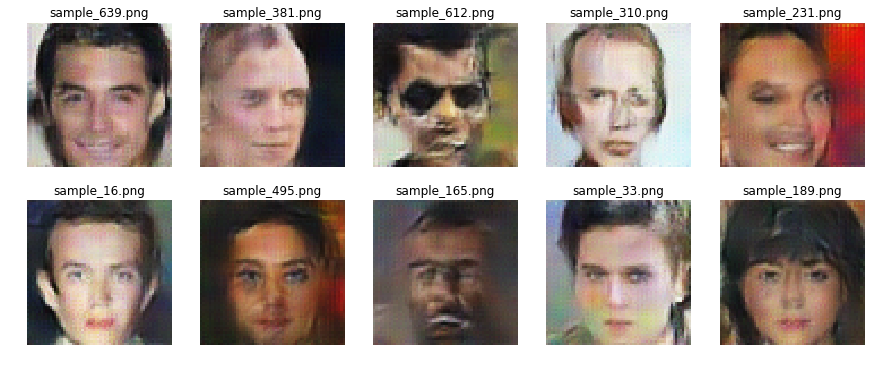

In [21]:
from os.path import join
def visualize(data_path, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n, filename in enumerate(np.random.choice(os.listdir(data_path), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img = plt.imread(join(data_path, filename))
        plt.imshow(img)
        plt.title(filename)
    plt.show()
visualize(new_samples_dir, n_cols=5, n_rows=2)

## Face interpolation

It is possible to interpolate between two faces generating two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ 

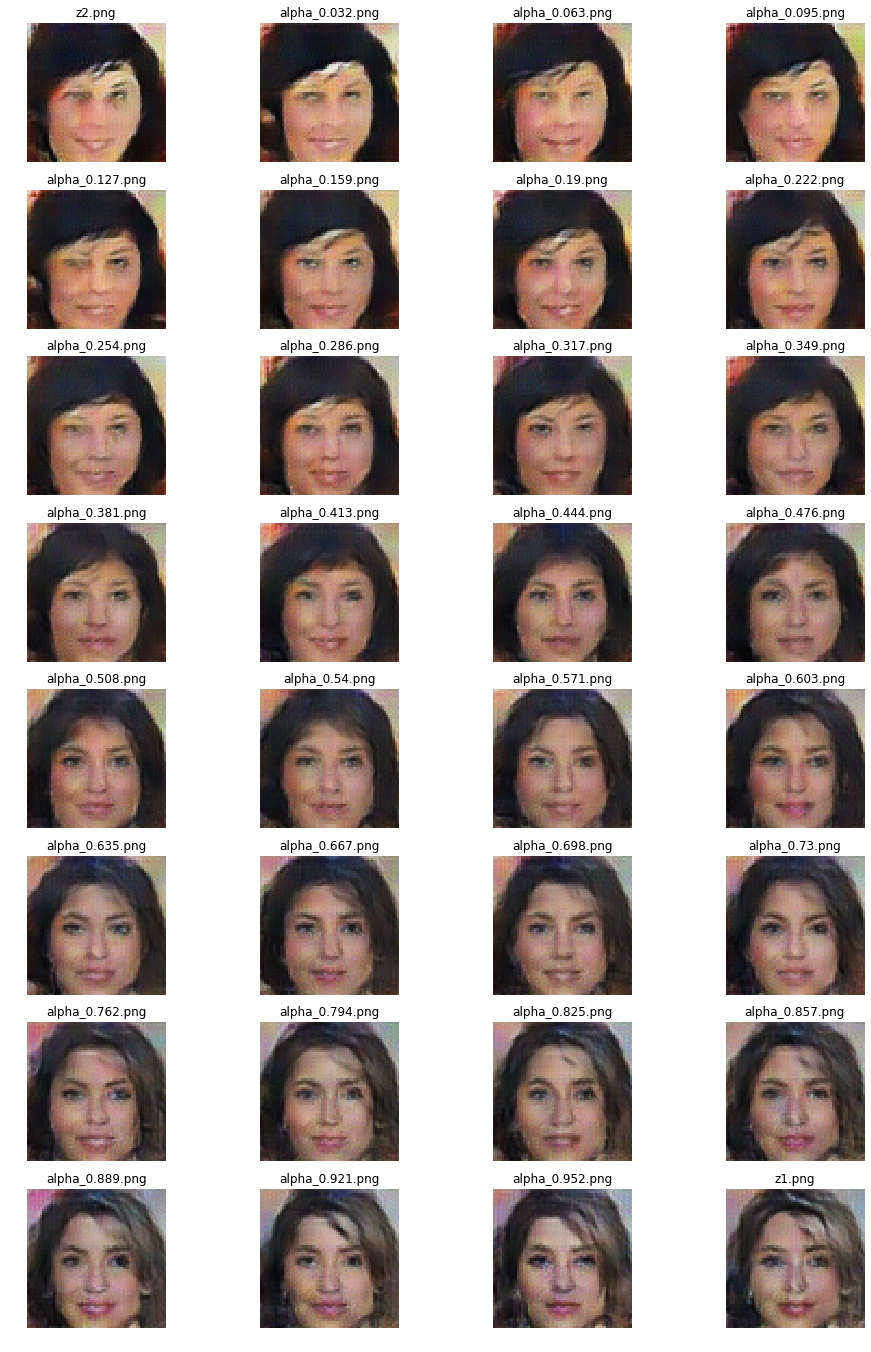

In [22]:
zs = np.random.uniform(-1, 1, [2, Z_DIM]).astype(np.float32)
alphas = np.linspace(0, 1, BATCH_SIZE)
batchz = np.zeros((BATCH_SIZE, Z_DIM))
for i, alpha in enumerate(alphas):
    batchz[i] = alpha*zs[0] + (1 - alpha)*zs[1]
samples = sess.run(G, feed_dict={z: batchz, is_training: False})
interpolation_dir = 'face_interpolation'
names = []
for i, sample in enumerate(samples):
    if i == 0:
        filename = 'z2.png'
        names.append(filename)
    elif i == len(samples) - 1:
        filename = 'z1.png'
        names.append(filename)
    else:
        filename = 'alpha_' + str(round(alphas[i], 3)) + '.png'
        if i&1 == 0 and i != len(samples) - 2:
            names.append(filename)
    plt.imsave(os.path.join(interpolation_dir, filename), (255*inverse_transform(sample)).astype(np.uint8))

plt.figure(figsize=(16, 24))
for i, name in enumerate(names):
    plt.subplot(8, 4, i+1)
    plt.axis('off')
    img = plt.imread(join(interpolation_dir, name))
    plt.imshow(img)
    plt.title(name)
plt.show()

## Smiles and other facial features

Similarly to interpolation it is possible to describe any facial feature as a vector $z$. In this case smiling.

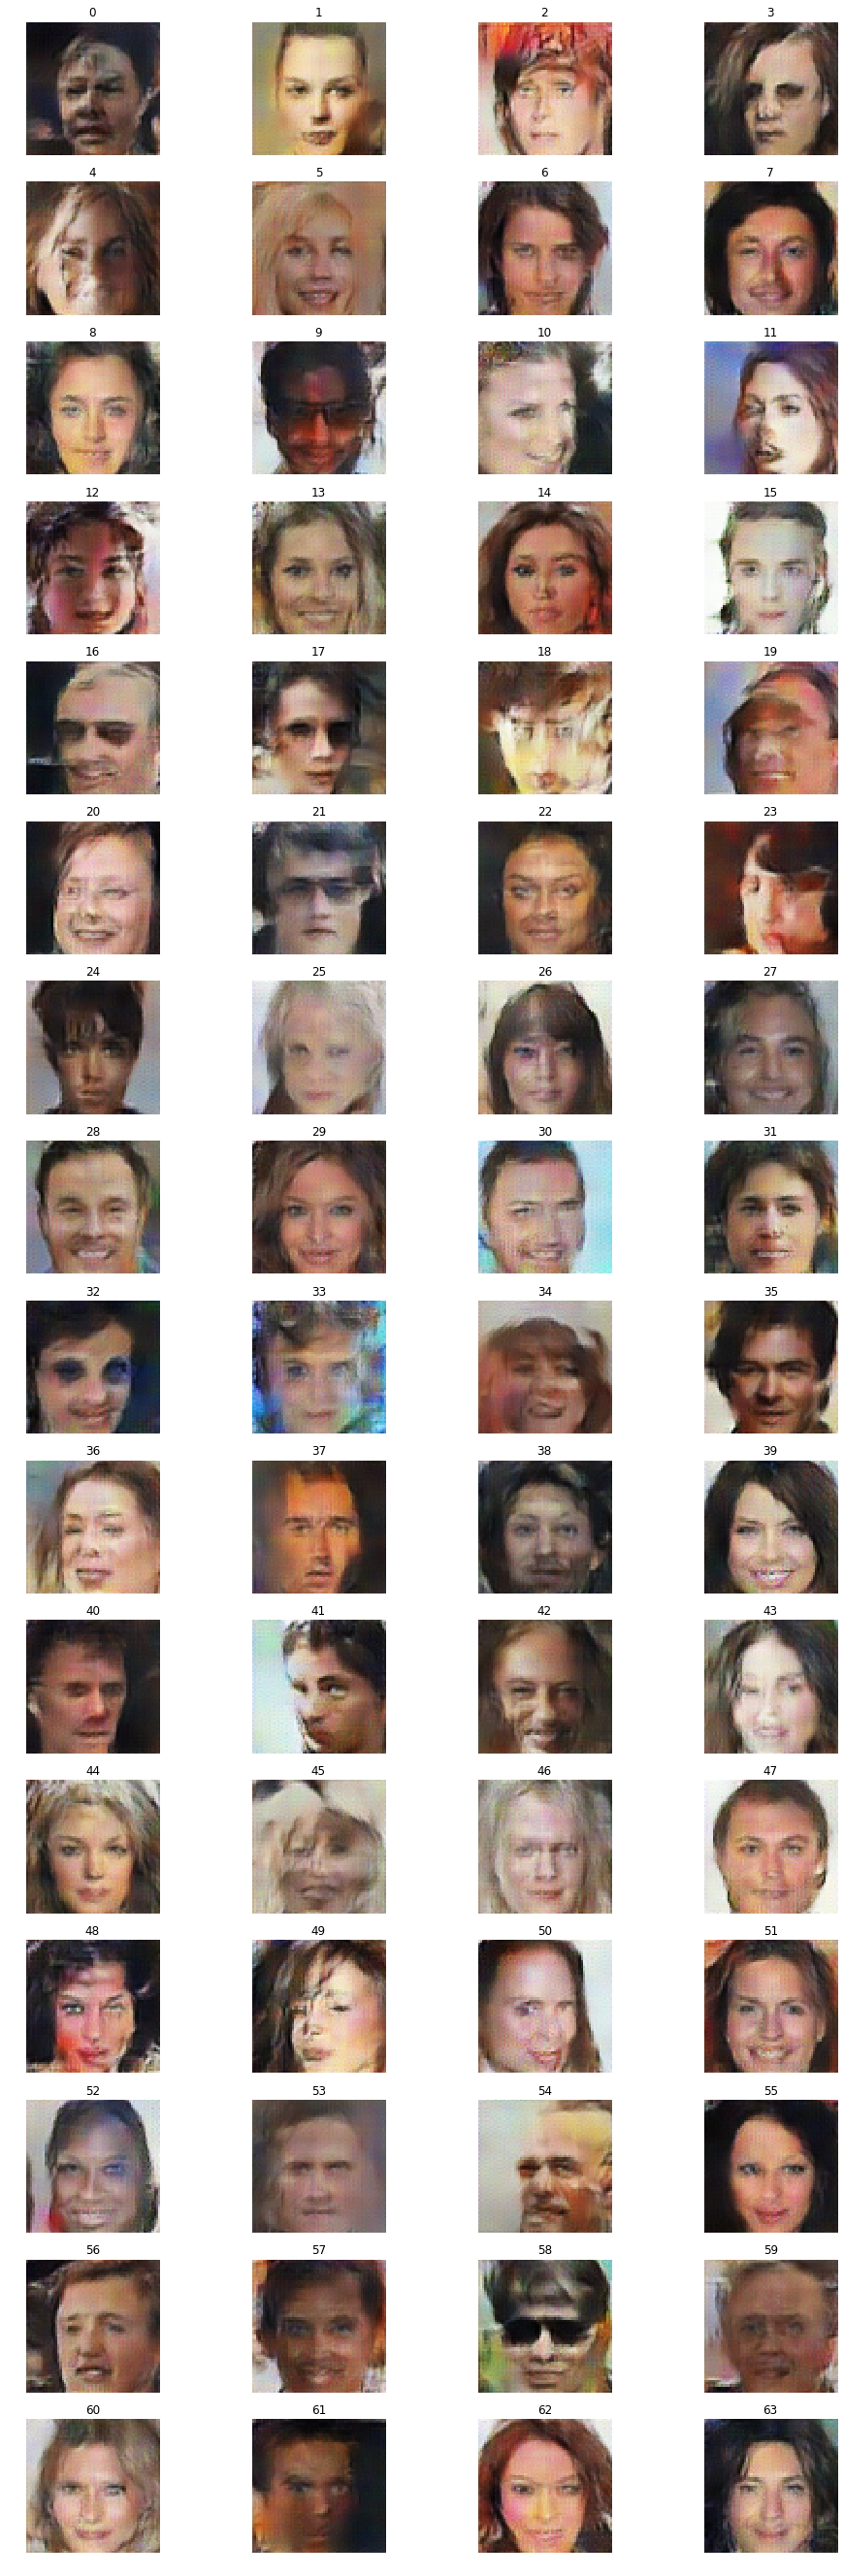

In [23]:
batchz = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
samples = sess.run(G, feed_dict={z: batchz, is_training: False})
plt.figure(figsize=(16, 48))
for i, sample in enumerate(samples):
    plt.subplot(16, 4, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow((255*inverse_transform(sample)).astype(np.uint8))
plt.show()